In [1]:
from neo4j import GraphDatabase, basic_auth
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
import os

In [2]:
load_dotenv()
DB_HOST = os.getenv("NEO4J_HOST")
DB_PORT = os.getenv("NEO4J_PORT")
DB_USER = os.getenv("NEO4J_USER")
DB_PASS = os.getenv("NEO4J_PASS")

In [3]:
driver = GraphDatabase.driver(f"bolt://{DB_HOST}:{DB_PORT}", auth=basic_auth(DB_USER, DB_PASS))
driver

In [4]:
with driver.session() as session:
    year_iter = list(filter(
        lambda item: 2024 > item > 1950,
        [a["bd"] for a in session.run("MATCH (n:Artist {type_1: true}) where n.ended < 0.25 and n.begin_date is not null RETURN distinct n.begin_date as bd").data()]
    ))

    colls = dict()
    for y in tqdm(year_iter):
        colls[y] = session.run(f"""
            MATCH (n:Artist {{begin_date: {y}, type_1: True}})-[:WORKED_IN]->(t:Track)
            WHERE n.ended < 0.25
            WITH n, collect(t) AS tracks
            WITH n, size(tracks) as all_count, [track IN tracks WHERE track.artist_count <> "1"] AS collab_tracks
            RETURN avg(toFloat(size(collab_tracks)) / toFloat(all_count)) AS c
        """).data()[0]["c"]

  0%|          | 0/73 [00:00<?, ?it/s]


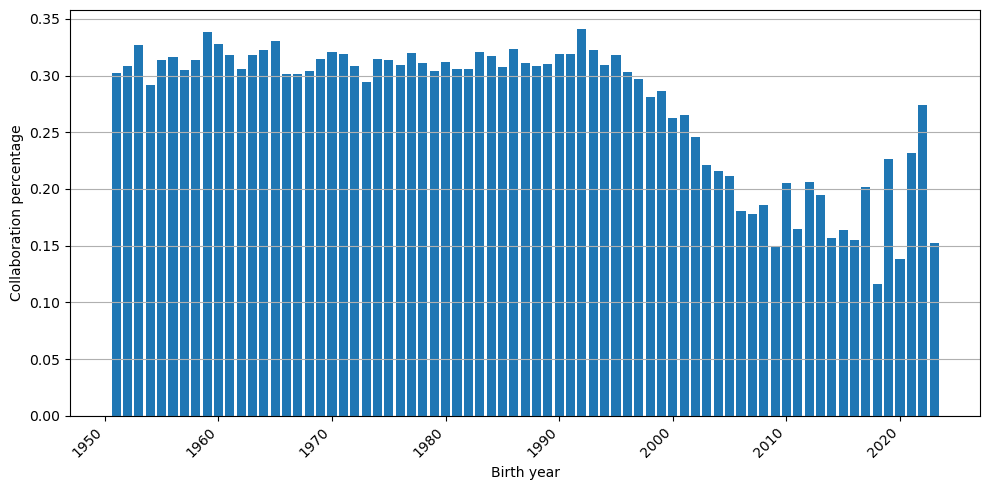

In [ ]:

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar(colls.keys(), colls.values())
plt.xlabel("Birth year")
plt.ylabel("Collaboration percentage")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis="y")
plt.show()


In [4]:
with driver.session() as session:
    year_iter = list(filter(
        lambda item: 2024 > item > 1950,
        [a["bd"] for a in session.run("MATCH (n:Artist {type_2: true}) where n.ended < 0.25 and n.begin_date is not null RETURN distinct n.begin_date as bd").data()]
    ))

    colls = dict()
    for y in tqdm(year_iter):
        colls[y] = session.run(f"""
            MATCH (n:Artist {{begin_date: {y}, type_2: True}})-[:WORKED_IN]->(t:Track)
            WHERE n.ended < 0.25
            WITH n, collect(t) AS tracks
            WITH n, size(tracks) as all_count, [track IN tracks WHERE track.artist_count <> "1"] AS collab_tracks
            RETURN avg(toFloat(size(collab_tracks)) / toFloat(all_count)) AS c
        """).data()[0]["c"]

100%|██████████| 73/73 [09:27<00:00,  7.77s/it]


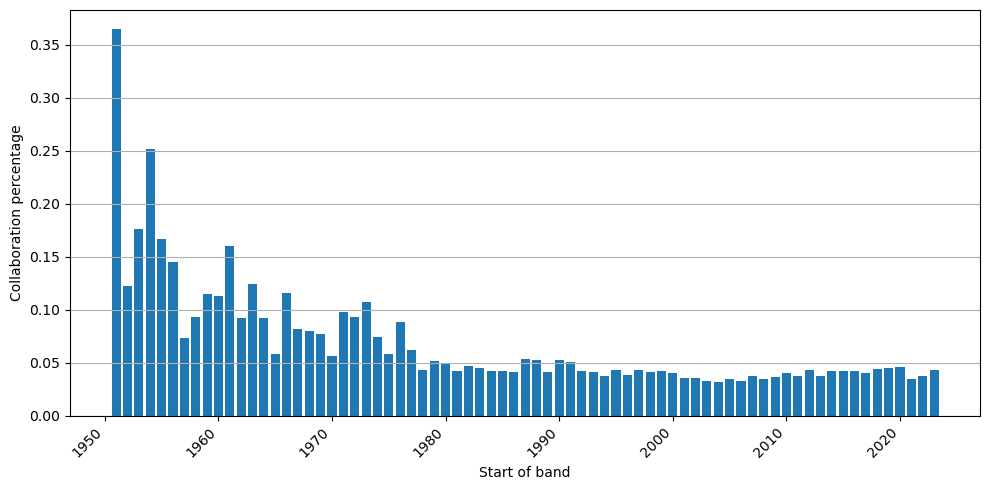

In [5]:

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar(colls.keys(), colls.values())
plt.xlabel("Start of band")
plt.ylabel("Collaboration percentage")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis="y")
plt.show()


In [6]:
driver.close()